# TP3 - Graphs in ML

Student: Lucas Gerretsen

Instructor: Pierre Perrault

Deadline: 26/12/2018

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Part 2

We implement *incremental k-centers* to solve an online semi-supervised problem of face recognition.

In [50]:
from importlib import reload
import Online_SSL.func as ssl
reload(ssl)

<module 'Online_SSL.func' from '/home/lucas/Documents/MVA/Graphs/TP3/code_material/Online_SSL/func.py'>

We first need to capture some various photos of the same faces for the experiments.

In [12]:
ssl.create_user_profile("lucas", faces_path = "./data/")

Profile found with 8 images.
Image 9 saved at ./data/faces/lucas/img_9.bmp
Image 10 saved at ./data/faces/lucas/img_10.bmp
Image 11 saved at ./data/faces/lucas/img_11.bmp
Image 12 saved at ./data/faces/lucas/img_12.bmp
Image 13 saved at ./data/faces/lucas/img_13.bmp


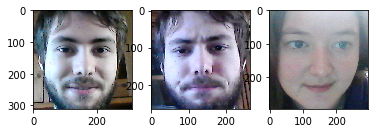

In [29]:
plt.subplot(1,3,1)
im = Image.open('data/faces/lucas/img_1.bmp')
plt.imshow(im)

plt.subplot(1,3,2)
im = Image.open('data/faces/lucas/img_4.bmp')
plt.imshow(im)

plt.subplot(1,3,3)
im = Image.open('data/faces/alice/img_8.bmp')
plt.imshow(im)

We then run our algorithm and provide it with a stream of faces from the webcam. Some frames were saved for visualization.

In [2]:
ssl.online_face_recognition(['alice','lucas'], faces_path='./data/', n_pictures=20)

Profile found with 16 images.
Profile found with 13 images.
[s]ave a frame ?
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved


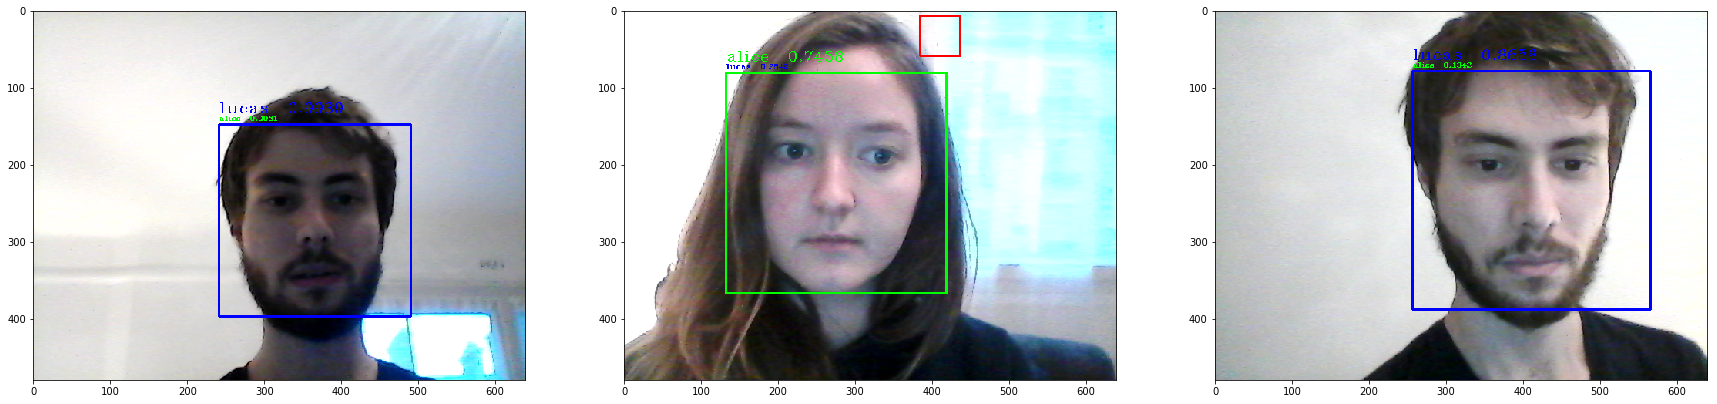

In [39]:
plt.figure(figsize=(30,30))

plt.subplot(1,3,1)
im = Image.open('experiments/261220181700/frame_45.png')
plt.imshow(im)

plt.subplot(1,3,2)
im = Image.open('experiments/261220181700/frame_94.png')
plt.imshow(im)

plt.subplot(1,3,3)
im = Image.open('experiments/261220181700/frame_376.png')
plt.imshow(im)


### Q2.3

With our algorithm, the graph we build has a fixed maximum number of nodes (in our case, set to 50 centroids). Building a knn graph with a good $k$ (here `k=10`) should then be easier than if we had a variable number of nodes (remember that the connectivity of a knn graph depends on the number of samples, while the connectivity of an $\epsilon$-graph does not); also, choosing a good $\epsilon$ for an $\epsilon$-graph would require to look into the obtained distances, depending on the experiments. We also set `var = 1e3` to have reasonable variations in the obtained distances (after applying `exp`).

Note that we do not use any learning of a feature representation, and apply distances directly on the raw pixels of the segmented faces. Such learning could help in improving the performances.

### Q2.4

We now allow our algorithm to label some faces as *unknown*. We consider a face to be unknown when the maximum score is below `0.5`. For this, we need to add laplacian regularization to allow faces to be closer to the virtual *sink* (here `laplacian_regularization=0.2`).

In [2]:
ssl.online_face_recognition(['alice'], faces_path='./data/', n_pictures=20)

Profile found with 16 images.
[s]ave a frame ?
saved
saved


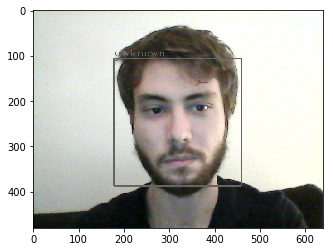

In [6]:
im = Image.open('experiments/261220181755/frame_125.png')
plt.imshow(im)

## Q3

Here we implement *Iterative Harmonic Function Solution* for a large scale problem, where, once again, we cannot use any closed form solution.

In [65]:
from Large_Scale_Label_Propagation import func as lslp
from importlib import reload
reload(lslp)

<module 'Large_Scale_Label_Propagation.func' from '/home/lucas/Documents/MVA/Graphs/TP3/code_material/Large_Scale_Label_Propagation/func.py'>

In [42]:
labels, acc = lslp.iterative_hfs(niter = 20)
print("Accuracy = ",acc)

Accuracy =  0.9998666666666667


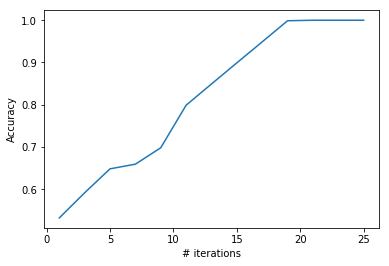

In [47]:
#niters = [1,2,3,5,7,10,20]
niters = np.arange(1,26,2)
n_exp = 5
accs = np.zeros((n_exp,len(niters)))
for it,niter in enumerate(niters):
    for it_exp in range(n_exp):
        labels, acc = lslp.iterative_hfs(niter = niter)
        accs[it_exp,it] = acc
        
plt.plot(niters,accs.mean(axis=0))
plt.xlabel("# iterations")
plt.ylabel("Accuracy")
plt.show()

This problem requires at least 20 iterations of harmonic estimations to obtain an accuracy of 100%. We could explore if there is a relation between the required number of iterations and the diameter of the graph.

### Q3.2

Adding regularization is equivalent to adding a sink connected to every node with a weight $w_0=$ `laplacian_regularization`, and fixed labels ($f(sink) = [0,\dots,0]^T$). Knowing this, our update becomes:

$$\forall i, \; f(x_i) = \frac{\sum_{i \sim j} f(x_j) w_{i,j}}{w_0 + \sum_{i \sim j} w_{i,j}}$$